In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal, LogNormal
import scipy.io as sio
import h5py

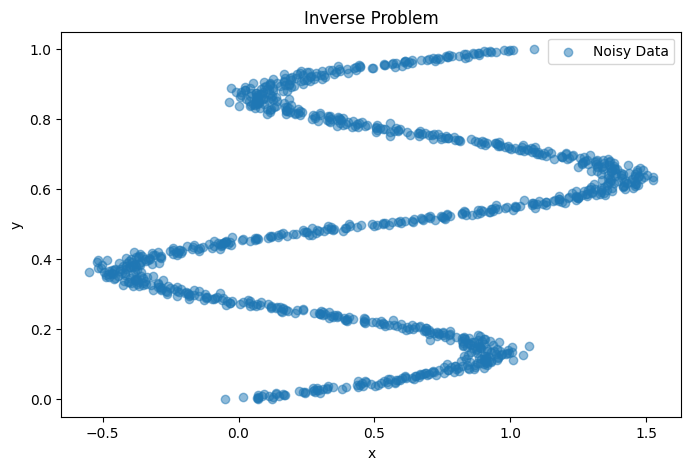

In [2]:
def data_generator():
    t = np.linspace(0, 1, 1000)
    # t = np.logspace(0.5,1,1000)  # from 1e0.5 to 1e1 seconds, 1000 points
    # Add noise (Gaussian)
    noise = np.random.normal(0, 0.05, size=t.shape)  # mean=0, std=0.05

    # Compute x using the formula
    x = t + 0.8 * np.sin(4 * np.pi * t) + noise
    return x.reshape(-1,1), t.reshape(-1,1)

x_train, y_train = data_generator()

# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, alpha=0.5, label="Noisy Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Inverse Problem")
plt.show()

In [3]:
# Define the Mixture Density Network
class MDN(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, num_gaussians=5):
        super(MDN, self).__init__()
        self.num_gaussians = num_gaussians
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
            
        )
        self.pi_layer = nn.Linear(32, num_gaussians)  # Mixing coefficients
        self.mu_layer = nn.Linear(32, num_gaussians)  # Means of Gaussians
        self.sigma_layer = nn.Linear(32, num_gaussians)  # Standard deviations
    
    def forward(self, x):
        h = self.fc(x)
        pi = torch.softmax(self.pi_layer(h), dim=1)  # Mixing coefficients (softmax)
        mu = self.mu_layer(h)  # Means
        sigma =  torch.exp(self.sigma_layer(h)).clamp(min=0.005)  # Standard deviations (exp for positivity)
        return pi, mu, sigma



In [4]:
# Define the Negative Log Likelihood loss for MDN
def mdn_loss(pi, mu, sigma, y, disttype = "Normal"):
    y = y.expand(-1, mu.shape[-1])  # Fix dimension expansion
    if disttype == "Normal":
        normal_dist = Normal(mu, sigma)
        likelihoods = torch.exp(normal_dist.log_prob(y))  # Due to numerical instability we first take a log and then exp
    else:
        log_normal_dist = LogNormal(mu, sigma)
        likelihoods = torch.exp(log_normal_dist.log_prob(y))
    weighted_likelihoods = pi * likelihoods  # Weight by mixing coefficients
    loss = -torch.log(weighted_likelihoods.sum(dim=1) + 1e-8).mean()  # Log sum exp trick
    return loss

In [6]:
# Training the model
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

sample_model = MDN(1,1,10)
optimizer = optim.Adam(sample_model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = sample_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.0772
Epoch 50, Loss: 0.1887
Epoch 100, Loss: -0.0862
Epoch 150, Loss: -0.3603
Epoch 200, Loss: -0.6795
Epoch 250, Loss: -0.4923
Epoch 300, Loss: -1.2307
Epoch 350, Loss: -1.1041
Epoch 400, Loss: -1.3277
Epoch 450, Loss: -0.5715
Epoch 500, Loss: -1.5275
Epoch 550, Loss: -1.4671
Epoch 600, Loss: -0.0942
Epoch 650, Loss: -1.3236
Epoch 700, Loss: -1.4380
Epoch 750, Loss: -1.1812
Epoch 800, Loss: -1.5672
Epoch 850, Loss: -1.6221
Epoch 900, Loss: -1.2696
Epoch 950, Loss: -1.6822
Epoch 1000, Loss: -1.2327
Epoch 1050, Loss: -1.8838
Epoch 1100, Loss: -1.6725
Epoch 1150, Loss: -1.8897
Epoch 1200, Loss: -1.9823
Epoch 1250, Loss: -1.9623
Epoch 1300, Loss: -2.0648
Epoch 1350, Loss: -2.1026
Epoch 1400, Loss: -2.0866
Epoch 1450, Loss: -2.0911
Epoch 1500, Loss: -1.9851
Epoch 1550, Loss: -1.9126
Epoch 1600, Loss: -2.1528
Epoch 1650, Loss: -2.0854
Epoch 1700, Loss: -1.9460
Epoch 1750, Loss: -2.1804
Epoch 1800, Loss: -2.1788
Epoch 1850, Loss: -2.0720
Epoch 1900, Loss: -2.1495
Epoch 1950,

In [5]:
# Final PDF calculation function (same as before)
def final_pdf(pi, mu, sigma, x, disttype="Normal"):
    pdf_values = torch.zeros(x.shape[0], pi.shape[1])  # [1000, 5]
    
    # Compute the individual PDF values for each Gaussian component
    for i in range(pi.shape[1]):  # num_gaussians
        if disttype=="Normal":
            dist = Normal(mu[:, i], sigma[:, i])
            pdf_values[:, i] = dist.log_prob(x).exp()  # Exponentiate to get the actual PDF
        else:
            dist = LogNormal(mu[:, i], sigma[:, i])
            pdf_values[:, i] = dist.log_prob(x).exp()  # Exponentiate to get the actual PDF
    
    # Weight the PDFs by the mixing coefficients (pi)
    weighted_pdf = pdf_values * pi  # Broadcasting pi across [1000, 5]
    
    # Sum the weighted PDFs over all components
    final_pdf_values = weighted_pdf.sum(dim=1)  
    # for Nomral torch.trapz(final_pdf_values, x) must be 1
    # for LogNormal torch.trapz(final_pdf_values, x) must be 1
    return final_pdf_values

# Sampling from the combined PDF based on the learned model parameters
def sample_from_combined_pdf(pi, mu, sigma, num_samples=100, disttype="Normal"):
    # print(num_samples)
    """
    Sample 'num_samples' values from the final combined distribution using the CDF.
    
    pi: mixing coefficients (5 values)
    mu: means of the 5 Gaussians
    sigma: standard deviations of the 5 Gaussians
    num_samples: number of samples to generate (default is 100)
    """
    if disttype=="Normal":
        x_values = torch.linspace(-10, 10, steps=1000)  # Define the range for sampling
    else:
        x_values = torch.logspace(-5, 5, steps=1000)  # Define the range for sampling

    
    pdf_values = final_pdf(pi, mu, sigma, x_values, disttype)  # Compute the PDF
    
    # Normalize the PDF to get the CDF
    cdf_values = torch.cumsum(pdf_values, dim=0)
    cdf_values = cdf_values / cdf_values[-1]  # Normalize so that CDF ends at 1
    
    # Generate 'num_samples' random values to sample from the CDF
    u = torch.rand(num_samples)  # Generate random values to sample from the CDF
    
    samples = []
    for val in u:
        sample_index = (cdf_values > val).nonzero(as_tuple=True)[0][0].item()
        sample = x_values[sample_index]
        samples.append(sample)
    
    return torch.tensor(samples)



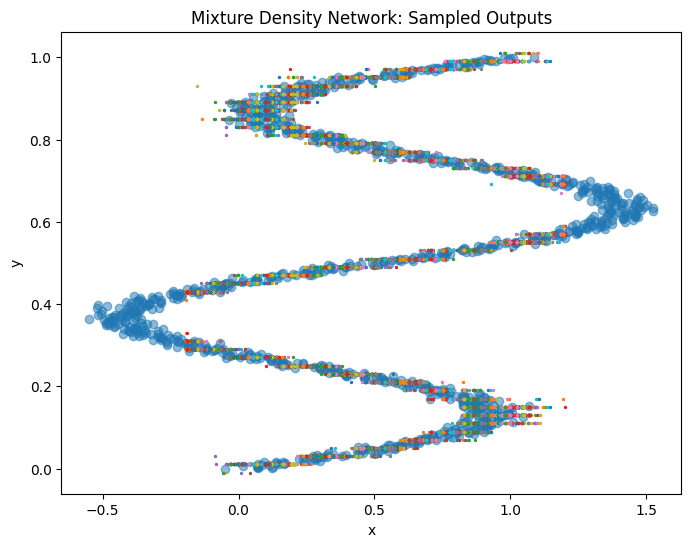

In [ ]:
# Example usage:
x_test = torch.rand(500, 1)*2-0.5  # 500 values of x_test (batch of 500)
pi, mu, sigma = sample_model(x_test)  # Get the corresponding pi, mu, sigma

# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

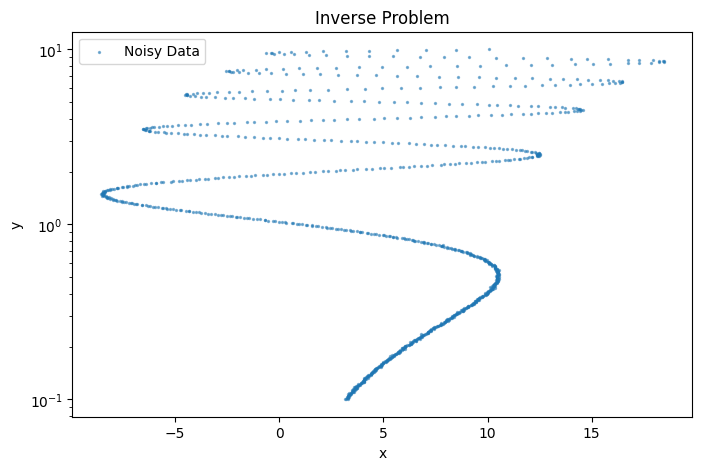

In [45]:
def data_generator():
    # t = np.linspace(0, 1, 1000)
    t = np.logspace(-1,1,1000)  # from 1e0.5 to 1e1 seconds, 1000 points
    # Add noise (Gaussian)
    noise = np.random.normal(0, 0.05, size=t.shape)  # mean=0, std=0.05

    # Compute x using the formula
    x = t + 10 * np.sin(1 * np.pi * t) + noise
    return x.reshape(-1,1), t.reshape(-1,1)

x_train, y_train = data_generator()

# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, alpha=0.5, label="Noisy Data",s=2)
plt.xlabel("x")
plt.ylabel("y")
plt.yscale('log')
plt.legend()
plt.title("Inverse Problem")
plt.show()

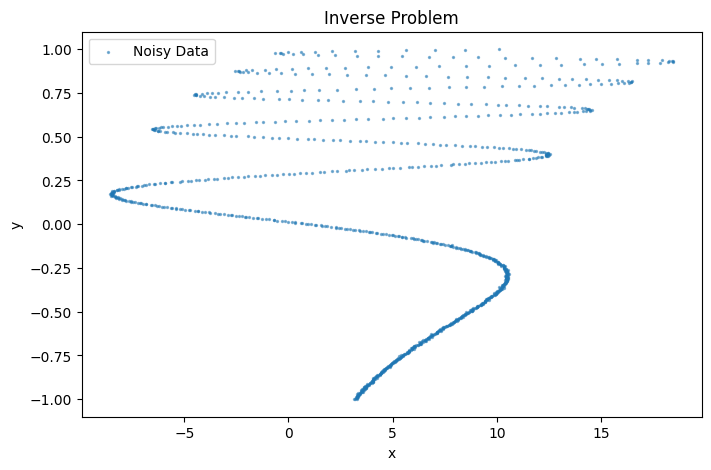

In [46]:
# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, np.log10(y_train), alpha=0.5, label="Noisy Data",s=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Inverse Problem")
plt.show()

In [47]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(np.log(y_train), dtype=torch.float32)

sample_model_log = MDN(1,1,100)
optimizer = optim.Adam(sample_model_log.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = sample_model_log(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.8095
Epoch 50, Loss: 0.8854
Epoch 100, Loss: 0.3451
Epoch 150, Loss: 0.6571
Epoch 200, Loss: 1.5532
Epoch 250, Loss: 0.6120
Epoch 300, Loss: 1.6551
Epoch 350, Loss: 0.8642
Epoch 400, Loss: -0.1792
Epoch 450, Loss: 1.3238
Epoch 500, Loss: 0.3277
Epoch 550, Loss: 0.8798
Epoch 600, Loss: -0.1463
Epoch 650, Loss: -0.3578
Epoch 700, Loss: -0.2768
Epoch 750, Loss: -0.8296
Epoch 800, Loss: -0.5170
Epoch 850, Loss: -0.8064
Epoch 900, Loss: -0.9241
Epoch 950, Loss: 0.0723
Epoch 1000, Loss: -0.4737
Epoch 1050, Loss: -0.6575
Epoch 1100, Loss: -1.3981
Epoch 1150, Loss: -1.0023
Epoch 1200, Loss: -1.3029
Epoch 1250, Loss: -1.1791
Epoch 1300, Loss: -0.7428
Epoch 1350, Loss: -0.7609
Epoch 1400, Loss: -1.2279
Epoch 1450, Loss: -1.6208
Epoch 1500, Loss: -1.1093
Epoch 1550, Loss: -1.6475
Epoch 1600, Loss: -1.5543
Epoch 1650, Loss: -1.2360
Epoch 1700, Loss: -1.3870
Epoch 1750, Loss: -1.5091
Epoch 1800, Loss: -1.7444
Epoch 1850, Loss: -1.7445
Epoch 1900, Loss: -1.5387
Epoch 1950, Loss: -1.

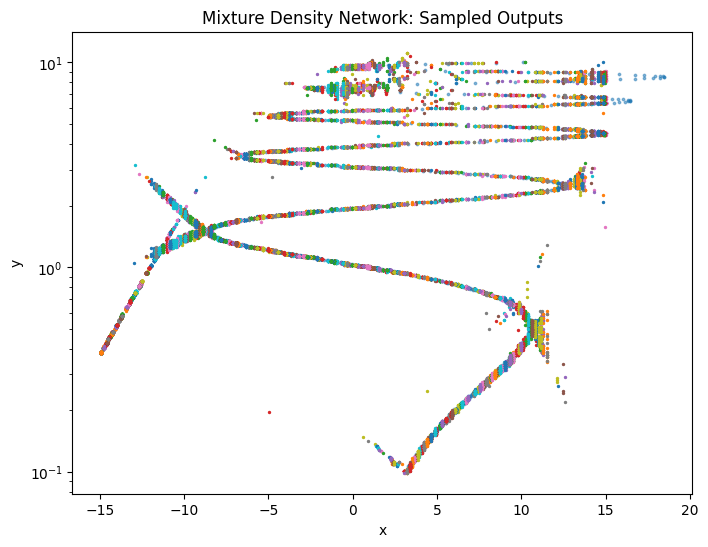

: 

In [ ]:
# Example usage:
x_test = torch.rand(500, 1)*30-15  # 500 values of x_test (batch of 500)
pi, mu, sigma = sample_model_log(x_test)  # Get the corresponding pi, mu, sigma

# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), np.exp(y_train.numpy()), alpha=0.5, label='Training Data',s=3)

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), np.exp(y_s), s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.yscale('log')
plt.show()

In [13]:
HotWireWT7 = h5py.File(r'SGFV_param_HotWT7.mat','r')
T_domain_WT7 = np.array(HotWireWT7.get('T_domain_WT7')).T
X_domain_WT7 = np.array(HotWireWT7.get('X_domain_WT7')).T
res_WT7 = np.array(HotWireWT7.get('res_WT7'))

VF_HotWT7 = HotWireWT7['VF_HotWT7']
VF_HotWT7_u_tau = VF_HotWT7['u_tau'][0]


duNN_refs = HotWireWT7['duNN_HotWT7']
maxmin_pairs_cell_HotWT7_refs = HotWireWT7['value_pairs_cell_HotWT7']
duwrtlocalmaxmin_HotWT7_refs = HotWireWT7['duwrtlocalmaxmin_HotWT7']

# To dereference:
duNN_HotWT7_list = []

for ref in duNN_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        duNN_HotWT7_list.append(array_data)

duwrtlocalmaxmin_HotWT7_list = []

for ref in duwrtlocalmaxmin_HotWT7_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        duwrtlocalmaxmin_HotWT7_list.append(array_data)

maxmin_pairs_HotWT7_list = []

for ref in maxmin_pairs_cell_HotWT7_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        maxmin_pairs_HotWT7_list.append(array_data)


min_values = maxmin_pairs_HotWT7_list[0][1]/VF_HotWT7_u_tau
max_values = maxmin_pairs_HotWT7_list[0][0]/VF_HotWT7_u_tau

In [14]:
Given_min_model = MDN(1,1,5)
optimizer = optim.Adam(Given_min_model.parameters(), lr=0.01)

x_train = torch.tensor(min_values.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(max_values.reshape(-1,1), dtype=torch.float32)

In [15]:
# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_min_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 2.5164
Epoch 50, Loss: 1.3588
Epoch 100, Loss: 1.2401
Epoch 150, Loss: 1.1743
Epoch 200, Loss: 1.1597
Epoch 250, Loss: 1.1872
Epoch 300, Loss: 1.1747
Epoch 350, Loss: 1.1907
Epoch 400, Loss: 1.1377
Epoch 450, Loss: 1.1647
Epoch 500, Loss: 1.1331
Epoch 550, Loss: 1.1901
Epoch 600, Loss: 1.1218
Epoch 650, Loss: 1.1218
Epoch 700, Loss: 1.1158
Epoch 750, Loss: 1.1026
Epoch 800, Loss: 1.1045
Epoch 850, Loss: 1.1593
Epoch 900, Loss: 1.1253
Epoch 950, Loss: 1.1362
Epoch 1000, Loss: 1.1759
Epoch 1050, Loss: 1.1039
Epoch 1100, Loss: 1.1042
Epoch 1150, Loss: 1.1078
Epoch 1200, Loss: 1.0979
Epoch 1250, Loss: 1.1211
Epoch 1300, Loss: 1.0942
Epoch 1350, Loss: 1.1097
Epoch 1400, Loss: 1.0921
Epoch 1450, Loss: 1.1235
Epoch 1500, Loss: 1.1755
Epoch 1550, Loss: 1.1151
Epoch 1600, Loss: 1.1071
Epoch 1650, Loss: 1.0911
Epoch 1700, Loss: 1.1094
Epoch 1750, Loss: 1.0965
Epoch 1800, Loss: 1.1791
Epoch 1850, Loss: 1.0979
Epoch 1900, Loss: 1.0903
Epoch 1950, Loss: 1.1031
Epoch 2000, Loss: 1.086

In [15]:
'''If we want do inferencing'''
Given_min_model.load_state_dict(torch.load('G:\My Drive\Research\VFfeaturedVorX\Given_min_model.pth'))
Given_min_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

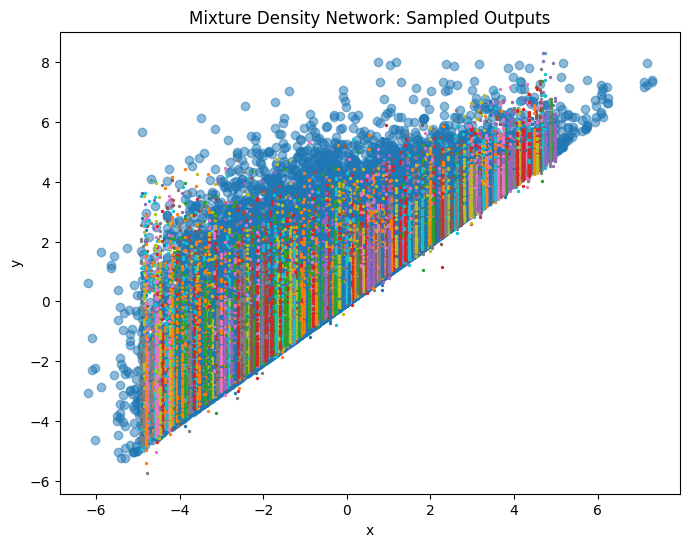

In [16]:
x_test = torch.rand(500, 1)*10-5.0
pi, mu, sigma = Given_min_model(x_test)


# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [19]:
# Saving the trained model
torch.save(Given_min_model.state_dict(), 'Given_min_model.pth')

In [24]:
Given_max_model = MDN(1,1,5)
optimizer = optim.Adam(Given_max_model.parameters(), lr=0.01)

x_train = torch.tensor(max_values.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(min_values.reshape(-1,1), dtype=torch.float32)

In [25]:
# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_max_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 2.2971
Epoch 50, Loss: 1.2884
Epoch 100, Loss: 1.1627
Epoch 150, Loss: 1.1610
Epoch 200, Loss: 1.1251
Epoch 250, Loss: 1.0778
Epoch 300, Loss: 1.0873
Epoch 350, Loss: 1.0808
Epoch 400, Loss: 1.0776
Epoch 450, Loss: 1.0587
Epoch 500, Loss: 1.0678
Epoch 550, Loss: 1.0533
Epoch 600, Loss: 1.0904
Epoch 650, Loss: 1.0671
Epoch 700, Loss: 1.1280
Epoch 750, Loss: 1.0545
Epoch 800, Loss: 1.0871
Epoch 850, Loss: 1.0712
Epoch 900, Loss: 1.1367
Epoch 950, Loss: 1.0699
Epoch 1000, Loss: 1.0721
Epoch 1050, Loss: 1.0633
Epoch 1100, Loss: 1.0784
Epoch 1150, Loss: 1.0783
Epoch 1200, Loss: 1.1149
Epoch 1250, Loss: 1.0747
Epoch 1300, Loss: 1.0559
Epoch 1350, Loss: 1.0660
Epoch 1400, Loss: 1.0747
Epoch 1450, Loss: 1.0644
Epoch 1500, Loss: 1.0653
Epoch 1550, Loss: 1.0660
Epoch 1600, Loss: 1.0710
Epoch 1650, Loss: 1.0876
Epoch 1700, Loss: 1.0602
Epoch 1750, Loss: 1.0703
Epoch 1800, Loss: 1.0491
Epoch 1850, Loss: 1.0876
Epoch 1900, Loss: 1.0467
Epoch 1950, Loss: 1.1020
Epoch 2000, Loss: 1.059

In [27]:
'''If we want do inferencing'''
Given_max_model.load_state_dict(torch.load('G:\My Drive\Research\VFfeaturedVorX\Given_max_model.pth'))
Given_max_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

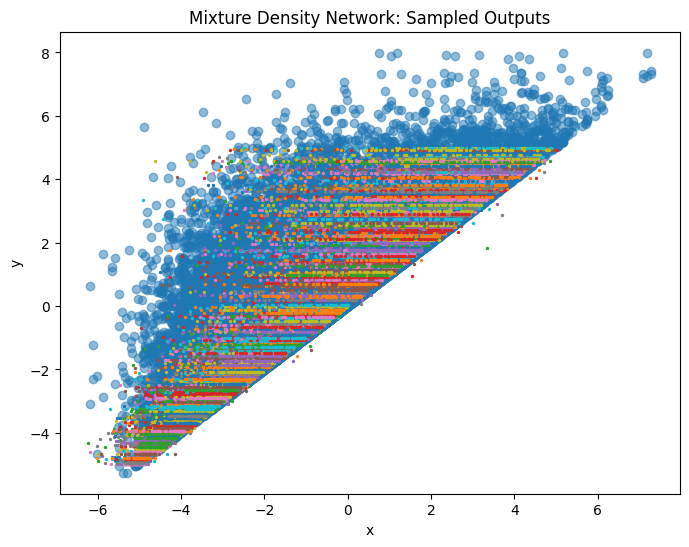

In [28]:
x_test = torch.rand(500, 1)*10-5.0
pi, mu, sigma = Given_max_model(x_test)
# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(y_train.numpy(),x_train.numpy() , alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(y_s, np.repeat(x_test[i].numpy(), num_samples), s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [26]:
# Saving the trained model
torch.save(Given_max_model.state_dict(), 'Given_max_model.pth')

In [37]:
duwrtlocalmaxmin_HotWT7 = duwrtlocalmaxmin_HotWT7_list[0]/VF_HotWT7_u_tau
duNN_HotWT7 = duNN_HotWT7_list[0]/(VF_HotWT7_u_tau*res_WT7[0,0])



x_train = torch.tensor(duwrtlocalmaxmin_HotWT7.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(duNN_HotWT7.reshape(-1,1), dtype=torch.float32)




# nonzero_mask = (y_train != 0).squeeze()

# # # Filter both x_train and y_train using the mask
# x_train = x_train[nonzero_mask]
# y_train= y_train[nonzero_mask]

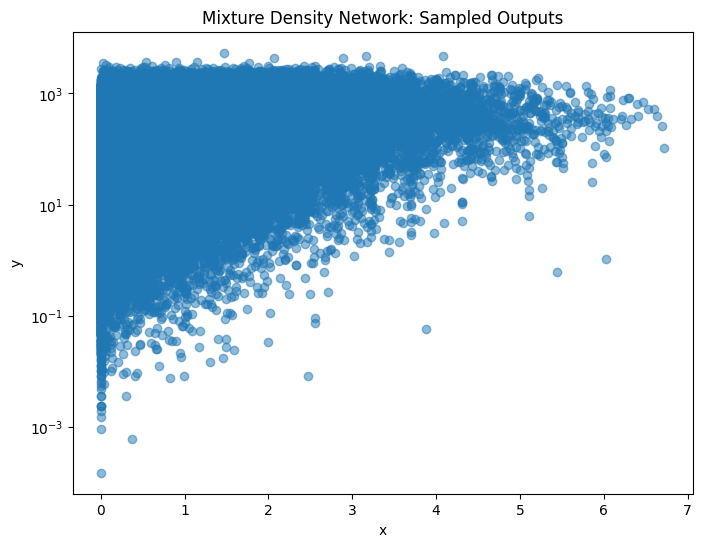

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')
plt.yscale('log')
plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

C:\Users\ehsan010\AppData\Local\Temp\ipykernel_5060\1953867521.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x_train.numpy(), np.log(y_train.numpy()), alpha=0.5, label='Training Data')


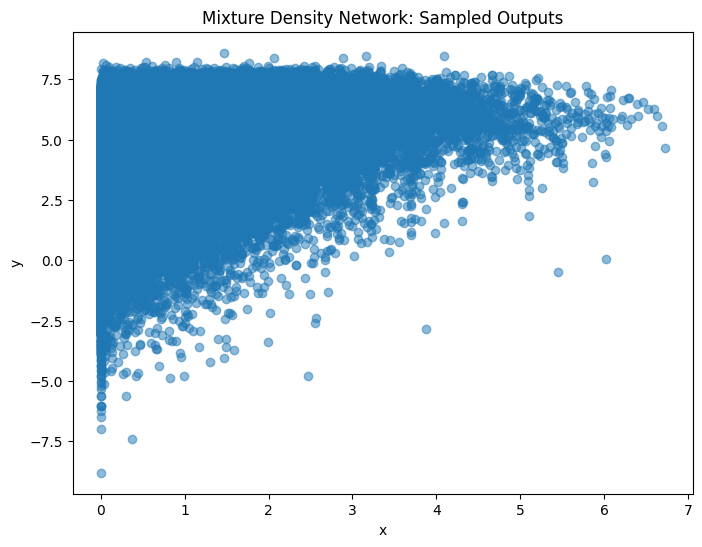

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), np.log(y_train.numpy()), alpha=0.5, label='Training Data')
plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [41]:
Given_dist_NLmin_NLmax_model = MDN(1,1,30)
optimizer = optim.Adam(Given_dist_NLmin_NLmax_model.parameters(), lr=0.01)

x_train = torch.tensor(duwrtlocalmaxmin_HotWT7.reshape(-1,1), dtype=torch.float32)
y_train = torch.log(torch.tensor(duNN_HotWT7.reshape(-1,1), dtype=torch.float32)+1e-10)
# Training loopl
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_dist_NLmin_NLmax_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 12.9834
Epoch 50, Loss: 1.4520
Epoch 100, Loss: 1.3644
Epoch 150, Loss: 1.3337
Epoch 200, Loss: 1.3317
Epoch 250, Loss: 1.3304
Epoch 300, Loss: 1.3262
Epoch 350, Loss: 1.3207
Epoch 400, Loss: 1.3149
Epoch 450, Loss: 1.3190
Epoch 500, Loss: 1.3107
Epoch 550, Loss: 1.3265
Epoch 600, Loss: 1.3076
Epoch 650, Loss: 1.3100
Epoch 700, Loss: 1.3106
Epoch 750, Loss: 1.3080
Epoch 800, Loss: 1.3076
Epoch 850, Loss: 1.3055
Epoch 900, Loss: 1.3038
Epoch 950, Loss: 1.3041
Epoch 1000, Loss: 1.3039
Epoch 1050, Loss: 1.3044
Epoch 1100, Loss: 1.3122
Epoch 1150, Loss: 1.3019
Epoch 1200, Loss: 1.3040
Epoch 1250, Loss: 1.3051
Epoch 1300, Loss: 1.3131
Epoch 1350, Loss: 1.3178
Epoch 1400, Loss: 1.3126
Epoch 1450, Loss: 1.3109
Epoch 1500, Loss: 1.3108
Epoch 1550, Loss: 1.3013
Epoch 1600, Loss: 1.2984
Epoch 1650, Loss: 1.3083
Epoch 1700, Loss: 1.3070
Epoch 1750, Loss: 1.2993
Epoch 1800, Loss: 1.2953
Epoch 1850, Loss: 1.3097
Epoch 1900, Loss: 1.3031
Epoch 1950, Loss: 1.2893
Epoch 2000, Loss: 1.29

In [22]:
'''If we want do inferencing'''
Given_dist_NLmin_NLmax_model.load_state_dict(torch.load('G:\My Drive\Research\VFfeaturedVorX\Given_dist_NLmin_NLmax_model.pth'))
Given_dist_NLmin_NLmax_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

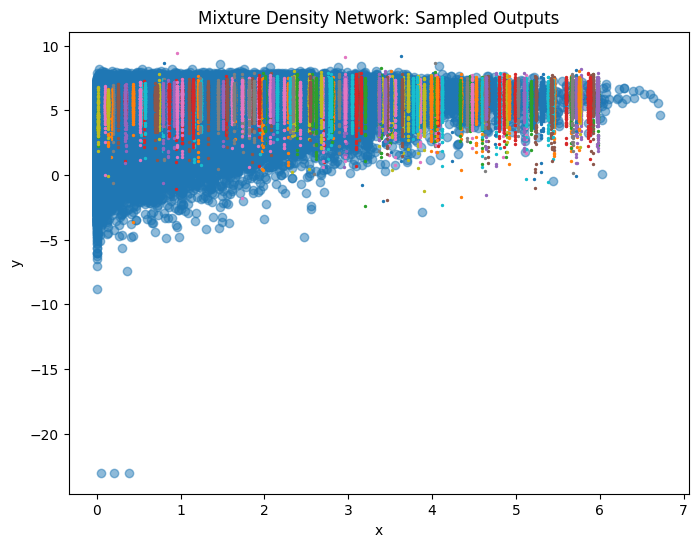

In [43]:
x_test = torch.rand(200, 1)*6
pi, mu, sigma = Given_dist_NLmin_NLmax_model(x_test)


# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 100  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

# plt.yscale('log')
plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [42]:
# Saving the trained model
torch.save(Given_dist_NLmin_NLmax_model.state_dict(), 'Given_dist_NLmin_NLmax_model.pth')